In [1]:
import sys

sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import plot

import matplotlib
import matplotlib.pyplot as plt
import textwrap

from tests.raster_processing.clip_test import raster_path as SMALL_RASTER_PATH
from eis_toolkit.training_data_tools.points_to_raster import points_to_raster

# Creating data points

In [3]:
positives = pd.DataFrame(
    {
        "x": [384824, 384803, 384807, 384793, 384773, 384785],
        "y": [6671284, 6671295, 6671277, 6671293, 6671343, 6671357],
    }
)
positives = gpd.GeoDataFrame(positives, geometry=gpd.points_from_xy(positives.x, positives.y, crs="EPSG:3067"))

# Creating binary raster from template raster

In [4]:
def plot_binary_raster_from_template_raster(template_raster_path):
    
    with rasterio.open(SMALL_RASTER_PATH) as temp_raster:

        transform=temp_raster.transform
        
        outarray,outmeta = points_to_raster(positives=positives,
                                            template_raster=temp_raster,
                                            nodata_value=-999)

        fig,axes = plt.subplots(1,2,figsize=(15,10))
        norm = plt.Normalize(vmax=np.nanmax(outarray), vmin=np.nanmin(outarray))
        cmap = 'gray'

        plot.show(temp_raster, ax=axes[0])
        axes[0].set_title('Template Raster with positives.', fontsize=15)
        positives.plot(ax=axes[0], facecolor='w', edgecolor='w')

        plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm,cmap=cmap),ax=axes)
        plot.show(outarray, transform, ax=axes[1], cmap='gray')
        axes[1].set_title(textwrap.fill('Converted binary raster from positives and template raster.', width=30), fontsize=15)
        

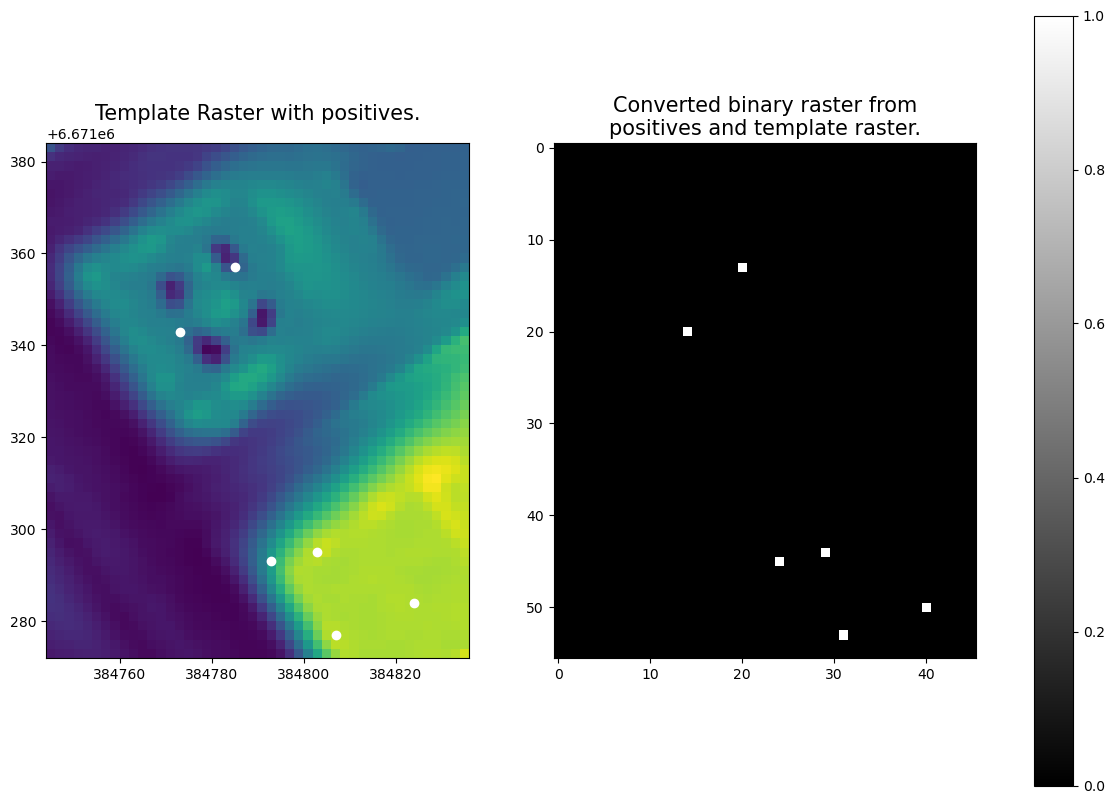

In [5]:
plot_binary_raster_from_template_raster(SMALL_RASTER_PATH)